# Homework 6

##### Data: HW6_data.csv

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 20th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators


**Dylan Randle**
<br>
**Michael S. Emanuel**
<br>
**Anna Davydova**
<br>
**Joe Davison**
<br>
*Listed in reverse alphabetical order this week*

<div class="answer-separator">
------------------------
</div>

In [2]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

## Question 1: Can I sample from F-R-I-E-N-D-S without rejection?  It's Important!

**Coding required**


*Haven't we made it obvious?* In HW 5 we were introduced to $X$ a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

*Haven't we made it clear?*  We were also introduced to $h$ the following function of $X$:

$$h(X) = \frac{1}{3\sqrt{2}\pi}\mathrm{exp}\left\{ -\frac{1}{18}\left( X - 5\right)^2\right\}$$


*Want us to spell it out for you?* Compute $\mathbb{E}[h(X)]$ via Monte Carlo simulation using the following sampling methods:

**1.1.** Rejection sampling with a normal proposal distribution and appropriately chosen parameters (aka rejection on steroids)

**1.2.** Importance sampling with a uniform proposal distribution

**1.3.** Importance sampling with a normal proposal distribution and appropriately chosen parameters

--

**1.4.** So far (in HWs 5 and 6) we've computed estimates of $\mathbb{E}[h(X)]$ for the following list of methods:

* Inverse Transform Sampling
* Rejection Sampling with a uniform proposal distribution (rejection sampling in a rectangular box with uniform probability of sampling any x)
* Rejection sampling with a normal proposal distribution and appropriately chosen parameters (aka rejection on steroids)
* Importance sampling with a uniform proposal distribution
* Importance sampling with a normal proposal distribution and appropriately chosen parameters.

Compute the variance of each estimate of $\mathbb{E}[h(X)]$ you calculated in this list. Which sampling methods and associated proposal distributions would you expect based on discussions from lecture to have resulted in lower variances? How well do your results align with these expectations?

**Gratuitous Titular Reference**:  Annemarie and Marshmello's [F-R-I-E-N-D-S](https://www.youtube.com/watch?v=CY8E6N5Nzec) samples from French Hip Hop artist Rapsa's [42 Mesures à ta Sa(i)nté](https://www.youtube.com/watch?v=JivaoPSAgLI) a homage to his hometown of Saint-Étienne.

In [3]:
# Additional imports
from numpy import sqrt, exp, pi
from scipy.stats import norm
from scipy.integrate import quad
from time import time
import pickle
from typing import List, Dict

In [4]:
# Type aliases
from typing import Callable
funcType = Callable[[float], float]

# Set plot style
matplotlib.rcParams.update({'font.size': 20})

# Utility functions
# *************************************************************************************************
def range_inc(x: int, y: int = None, z: int = None) -> range:
    """Return a range inclusive of the end point, i.e. range(start, stop + 1, step)"""
    if y is None:
        (start, stop, step) = (1, x + 1, 1)
    elif z is None:
        (start, stop, step) = (x, y + 1, 1)
    elif z > 0:
        (start, stop, step) = (x, y + 1, z)
    elif z < 0:
        (start, stop, step) = (x, y - 1, z)
    return range(start, stop, step)


def arange_inc(x: float, y: float = None, z: float = None) -> np.ndarray:
    """Return a numpy arange inclusive of the end point, i.e. range(start, stop + 1, step)"""
    if y is None:
        (start, stop, step) = (1, x + 1, 1)
    elif z is None:
        (start, stop, step) = (x, y + 1, 1)
    elif z > 0:
        (start, stop, step) = (x, y + 1, z)
    elif z < 0:
        (start, stop, step) = (x, y - 1, z)
    return np.arange(start, stop, step)

# *************************************************************************************************
def load_vartbl(fname: str) -> Dict:
    """Load a dictionary of variables from a pickled file"""
    try:
        with open(fname, 'rb') as fh:
            vartbl = pickle.load(fh)
    except:
        vartbl = dict()
    return vartbl


def save_vartbl(vartbl: Dict, fname: str) -> None:
    """Save a dictionary of variables to the given file with pickle"""
    with open(fname, 'wb') as fh:
        pickle.dump(vartbl, fh)

In [4]:
# 1. Shared prerequisites for problem 1 (both parts)
def f_scalar(x: float):
    """The PDF, defined on scalars"""
    if x < 1:
        return 0
    elif x <= 3:
        return (1/12) * (x - 1)
    elif x <= 5:
        return (1/12) * (5 -x)
    elif x <= 7:
        return (1/6) * (x-5)
    elif x <= 9:
        return (1/6) * (9-x)
    else:
        return 0
    

def f_vec(x: np.ndarray) -> np.ndarray:
    """The PDF for problem 1; vectorized implementation"""
    # Initialize return vector of zeros
    y = np.zeros_like(x)
    # x in [1, 3)
    mask = (1 <= x) & (x < 3)
    y[mask] = (1/12) * (x[mask] - 1)
    # x in [3, 5)
    mask = (3 <= x) & (x < 5)
    y[mask] = (1/12) * (5 - x[mask])
    # x in [5, 7)
    mask = (5 <= x) & (x < 7)
    y[mask] = (1/6) * (x[mask]-5)
    # x <= 9
    mask = (7 < x) & (x <= 9)
    y[mask]= (1/6) * (9-x[mask])
    # Return the array of ys
    return y


def f(x):
    """The PDF; handles sclars or vectors appropriately"""
    if isinstance(x, np.ndarray):
        return f_vec(x)
    if isinstance(x, float) or isinstance(x, int):
        return f_scalar(x)
    raise ValueError('f(x) supports np.ndaraay, float, int.')


def h(x: float) -> float:
    """The function h(X) whose expectation we want to take"""
    # The normalizing constant
    a: float = 1.0 / (3 * sqrt(2) * pi)
    # The term in the exponential
    u: float = -(1/18)*(x-5)*(x-5)
    return a * exp(u)

# Limits of the support of f(x)
a: float = 1.0
b: float = 9.0
# Calculate the exact answer using scipy.integrate.quad
fh = lambda x : f(x) * h(x)
exp_exact, tol_exact = quad(fh, a, b)
print(f'The exact answer with scipy.integrate.quad is {exp_exact:0.8f} to a tolerance of {tol_exact:0.3e}.')

The exact answer with scipy.integrate.quad is 0.05885827 to a tolerance of 6.532e-16.


Proposal Distribution and Majorizer for rejection sampling.
mu=5.800000, sigma=2.338233, M=2.250974


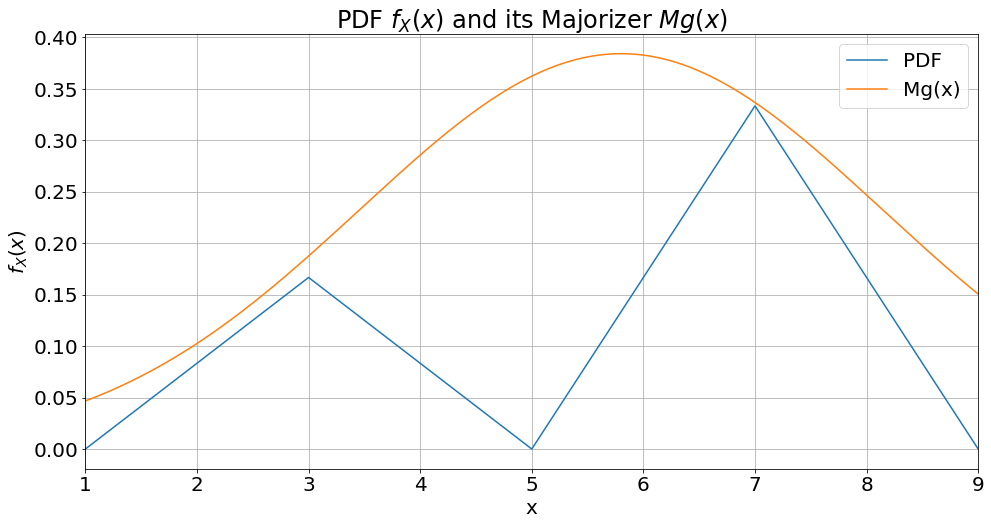

In [5]:
# 1.1. Rejection sampling with a normal proposal distribution and appropriately chosen parameters 
# Visualize PDF and design a proposal distribution

# Values for plots
plot_x = arange_inc(1, 9, 0.05)
plot_f = f(plot_x)

# Create a proposal distribution by hand by looking at the chart
# Experiment to get M as small as possible
mu1 = 5.8
sigma1: float = np.std(plot_x)*0.9
# Proposal distribution g(x) (NOT majorized)
g1: funcType = lambda x : norm.pdf(x, loc=mu1, scale=sigma1)
plot_g1 = g1(plot_x)
M1: float = np.max(plot_f / plot_g1)*1.01
plot_g1_maj = M1 * plot_g1
print(f'Proposal Distribution and Majorizer for rejection sampling.')
print(f'mu={mu1:0.6f}, sigma={sigma1:0.6f}, M={M1:0.6f}')
# Define the sampling distribution for the chosen proposal distribution g(x)
g1_sample = lambda : norm.rvs(loc=mu1, scale=sigma1)

# Plot the PDF f_X(x) and the majorizing distribution Mg(x)
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('PDF $f_X(x)$ and its Majorizer $Mg(x)$')
ax.set_xlabel('x')
ax.set_ylabel('$f_X(x)$')
ax.set_xlim([1,9])
ax.plot(plot_x, plot_f, label='PDF')
ax.plot(plot_x, plot_g1_maj, label='Mg(x)')
ax.legend()
ax.grid()
plt.show()

In [6]:
# 1.1 Compute E_f[h] using rejection sampling from a proposal distribution
def rejection_sample_proposal(f: funcType, g: funcType, g_sample: funcType, M: float, size: int):
    """
    Perform rejection sampling: 
    f: the probability density (PDF) we wish to sample
    g: the proposal distribution we use for candidate sample points
    g_sample: function to used to draw random samples with PDF g(x)
    M: the majorizer such that f(x) < Mg(x) on the support of f
    size: the number of samples
    """
    
    # Preallocate space for the drawn samples
    x_samples = np.zeros(size)
    # Count the number of samples drawn and attempts
    idx: int = 0
    attempts: int = 0
    # Continue drawing new samples until we've collected size of them
    # Folow the recipe in Lecutre 10, p. 14
    while idx < size:
        # Draw a random value of x from the proposal distribution
        x = g_sample()
        # Draw a random value of y on [0, 1]
        y: float = np.random.uniform()
        if y * M * g(x) <= f(x):
            # Save the sample in slot idx, then increment idx
            x_samples[idx] = x
            idx += 1
        # Always increment attempts
        attempts += 1
    # Return the list of samples as well as the number of attempts
    return x_samples, attempts

def expectation_mc(h, x_sample, wts = None):
    """Take the expectation of a function given samples
    h:          The function whose expectation we want to take
    x_sample:   The samples of the function
    weights:    The importance weights to use; optional, defaults to None (ignored)
    """
    E: float
    if wts is None:
        # Evaluate h(x) on the samples and return the mean if there were no weights
        E = np.mean(h(x_sample))
    else:
        # Evaluate h(x) on the samples and return the weighted average with the given importance weights
        E = np.average(a=h(x_sample), weights=wts)
    return E

# Set a consistent sample size used in all three parts of problem 1
sample_size: int = 10**4

# Draw a sample of x's from the normal proposal distribution
if 'x_samples_rs' not in globals():
    t0 = time()
    x_samples_rs, attempts = rejection_sample_proposal(f, g1, g1_sample, M1, sample_size)
    t1 = time()
    elapsed = t1 - t0
    print(f'Generated {sample_size} samples in {attempts} attempts using rejection sampling; {elapsed:0.2f} seconds.')
else:
    print(f'Using {sample_size} samples previously generated by rejection sampling.')

# Compute E_f[H] on these samples and report results
exp_h_rs: float = expectation_mc(h, x_samples_rs)
err_rs: float = np.abs(exp_h_rs - exp_exact)
print(f'Expectation of h(x) using Rejection Sampling: {exp_h_rs:0.6f}.  '
      f'Error = {err_rs:0.2e}\n')

Generated 10000 samples in 22559 attempts using rejection sampling; 3.23 seconds.
Expectation of h(x) using Rejection Sampling: 0.059025.  Error = 1.67e-04



In [7]:
# 1.2. Importance sampling with a uniform proposal distribution

# Define uniform proposal distribution's density (will only be used on [a, b]
def g_unif(x):
    if isinstance(x, np.ndarray):
        y = np.zeros_like(x)
        mask = (a <= x) & (x <= b)
        y[mask] = 1.0 / (b-a)
    if isinstance(x, float) or isinstance(x, int):
        if a <= x and x <= b:
            return 1.0 / (b-a)
        else:
            return 0


# Draw samples uniformly on [a, b]; we keep them all because we're doing importance sampling
x_samples_unif = np.random.uniform(low=a, high=b, size=sample_size)
print(f'Drew {sample_size} random samples on uniform proposal distribution.')
# The importance weights are just the ratio f(x) / g(x) on each sample
# Here the proposal g(x) is uniform, so g(x) = 1/(b-a)
wts_unif = f(x_samples_unif) * (b-a)
# Compute E_f[H] with these samples and importance weights; report results
exp_h_unif = expectation_mc(h, x_samples_unif, wts_unif)
err_unif: float = np.abs(exp_h_unif - exp_exact)
print(f'Expectation of h(x) using Uniform Sampling and Importance Weights: {exp_h_unif:0.6f}; '
      f'Error = {err_unif:0.2e}\n')

Drew 10000 random samples on uniform proposal distribution.
Expectation of h(x) using Uniform Sampling and Importance Weights: 0.059078; Error = 2.20e-04



mu=5.800000, sigma=2.338233, M2=0.135230


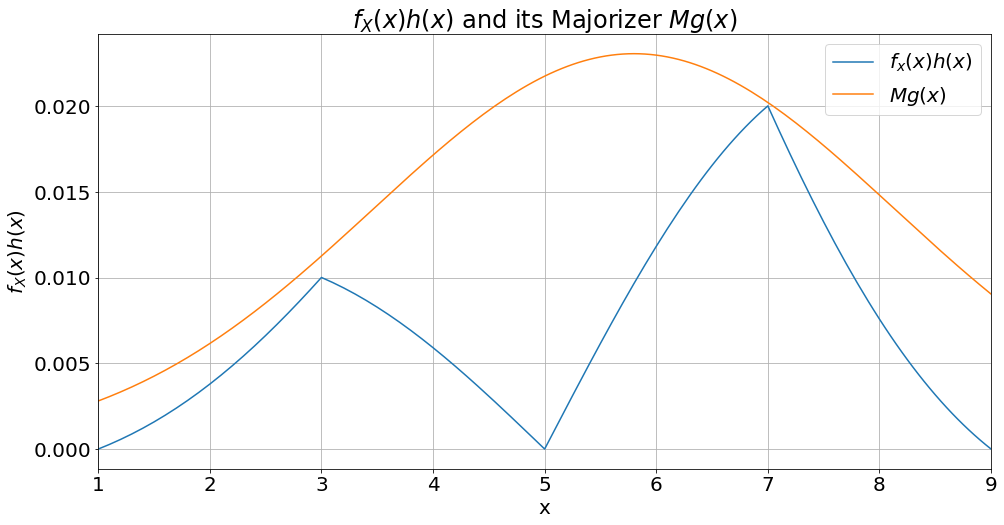

Expectation of h(x) using Normal Proposal Distribution & Importance Weights: 0.058758; Error 9.99e-05


In [8]:
# 1.3. Importance sampling with a normal proposal distribution and appropriately chosen parameters

# Create a proposal distribution by hand by looking at the chart
# This plot is to match f(x) h(x), not f(x)
plot_h = h(plot_x)
plot_fh = plot_f * plot_h
# Experiment to get M as small as possible
mu2 = 5.8
sigma2: float = np.std(plot_x)*0.9
# Proposal distribution g(x) (NOT majorized)
g2: funcType = lambda x : norm.pdf(x, loc=mu2, scale=sigma2)
plot_g2 = g2(plot_x)
M2: float = np.max(plot_fh / plot_g2)*1.01
plot_g2_maj = M2 * plot_g2
print(f'mu={mu2:0.6f}, sigma={sigma2:0.6f}, M2={M2:0.6f}')
# Define the sampling distribution for the chosen proposal distribution g(x)
# g2_sample = lambda size: norm.rvs(loc=mu2, scale=sigma2, size=size)

# Plot the PDF f_X(x) and the majorizing distribution Mg(x)
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('$f_X(x) h(x)$ and its Majorizer $Mg(x)$')
ax.set_xlabel('x')
ax.set_ylabel('$f_X(x) h(x)$')
ax.set_xlim([1,9])
ax.plot(plot_x, plot_fh, label='$f_x(x) h(x)$')
ax.plot(plot_x, plot_g2_maj, label='$Mg(x)$')
ax.legend()
ax.grid()
plt.show()

# Draw a sample of x's from the normal proposal distribution; keep them all because we're importance sampling
x_samples_norm = norm.rvs(loc=mu2, scale=sigma2, size=sample_size)
# The importance weights w(x) = f(x) / g(x)
wts_norm = f(x_samples_norm) / g2(x_samples_norm)
# Compute the E_f[H] on these samples and importance weights; report results
exp_h_norm = expectation_mc(h, x_samples_norm, wts_norm)
err_norm = np.abs(exp_h_norm - exp_exact)
print(f'Expectation of h(x) using Normal Proposal Distribution & Importance Weights: {exp_h_norm:0.6f}; '
      f'Error {err_norm:0.2e}')

In [9]:
# 1.4. So far (in HWs 5 and 6) we've computed estimates of  𝔼[h(X)]  for the following list of methods:

# (a) Inverse Transform Sampling
# (b) Rejection Sampling with a uniform proposal distribution 
#     (rejection sampling in a rectangular box with uniform probability of sampling any x)
# (c) Rejection sampling with a normal proposal distribution and appropriately chosen parameters (aka rejection on steroids)
# (d) Importance sampling with a uniform proposal distribution
# (e) Importance sampling with a normal proposal distribution and appropriately chosen parameters.

# Compute the variance of each estimate of  𝔼[h(X)] you calculated in this list. 
# Which sampling methods and associated proposal distributions would you expect based on discussions from lecture 
# to have resulted in lower variances? How well do your results align with these expectations?

# Lecture 10, p. 18: 
# For "regular" sampling, V_hat = V_f[h(x)] / N
# For importance sampling, V_hat = V_g[w(x) h(x)] / N

def weighted_variance(x: np.ndarray, wts: np.ndarray):
    """Compute the variance of an array with weights"""
    # Compute the weighted average
    wtd_avg = np.average(a=x, weights=wts)
    # Compute the difference to the weighted average
    dx = x - wtd_avg
    # The weighted variance is the weighted average of dx*dx    
    return np.average(a=dx*dx, weights=wts)

def exp_mc_var(h: funcType, x_samples):
    """Esimate variance of h(x) on sampled x."""
    # Number of samples
    N: int = x_samples.shape[0]
    # Compute the expected variance of h(x) with probability f(x): V_f[h(x)]
    h_x: np.ndarray = h(x_samples)
    f_x: np.ndarray = f(x_samples)
    h_var: float = weighted_variance(h_x, f_x)
    # Return the sample variance over N
    return h_var / N


def exp_mc_var_wtd(h: funcType, g: funcType, x_samples, wts):
    """Esimate variance of h(x) on sampled x."""
    # Number of samples
    N: int = x_samples.shape[0]
    # Compute the expected variance of w(x)h(x) with probability g(x): V_g[w(x)h(x)]
    wh_x: np.ndarray = wts * h(x_samples)
    g_x: np.ndarray = g(x_samples)
    wh_var: float = weighted_variance(wh_x, g_x)
    # Return the sample variance over N
    return wh_var / N


# *************************************************************************************************
print(f'\nExpected variance on MC integral with 5 sampling methods and {sample_size} samples.')

# The expected variance and standard deviation for all three sampling based approaches.
exp_var_samp = exp_mc_var(h, x_samples_norm)
exp_std_samp = sqrt(exp_var_samp)
# Report results
print(f'Estimated variance for all three sampling estimates with {sample_size} samples:')
print(f'Estimated variance = {exp_var_samp:0.3e}, standard deviation {exp_std_samp:0.3e}.')

# (d) Importance Sampling with unifrom proposal distribution
var_imp_unif = exp_mc_var_wtd(h, g_unif, x_samples_unif, wts_unif)
std_imp_unif = sqrt(var_imp_unif)
print(f'Importance Weighting with Uniform Proposal: variance = {var_imp_unif:0.3e}, std = {std_imp_unif:0.3e}.')

# (e) Importance Sampling with normal proposal distribution
var_imp_norm = exp_mc_var_wtd(h, g2, x_samples_norm, wts_norm)
std_imp_norm = sqrt(var_imp_unif)
print(f'Importance Weighting with Normal Proposal: variance = {var_imp_norm:0.3e}, std = {std_imp_norm:0.3e}.')


Expected variance on MC integral with 5 sampling methods and 10000 samples.
Estimated variance for all three sampling estimates with 10000 samples:
Estimated variance = 9.003e-09, standard deviation 9.489e-05.
Importance Weighting with Uniform Proposal: variance = 1.839e-07, std = 4.289e-04.
Importance Weighting with Normal Proposal: variance = 1.577e-07, std = 4.289e-04.


**1.4** In lecture we saw two formulas for the estimated variance, $\hat{V}$, of an expectation taken by Monte Carlo.
\begin{align}x^2\end{align}

\begin{align}
\hat{V} &= \frac{V_f[h(x)]}{N} \quad &\text{with "Regular" Sampling} \\
\hat{V} &= \frac{V_g[w(x)h(x)]}{N} \quad &\text{with Importance Sampling} \\
\end{align}

So the first observation here is that this formula will be *the same* for (a), (b), and (c) since it depends on only two factors, the variance $V_f[h(x)]$ and the number of samples, $N$.  The only difference in the sampling distribution is how efficient they are, i.e. how much work we have to do on the computer to generate samples.  Once the samples are in hand, their expected behavior is indistinguishable regardless of how they were generated.  The function `exp_mc_var` above performs this calculation, estimating a variance of 8.9e-9 and a standard deviation of 9.5e-5 for the three sampling distributions.  We can note that this standard deviation is in line with the three errors we computed by comparing our estimates to the exact answers with `scipy.integrate.quad`.

What about the two calculations with importance based weights?  The function `exp_mc_var_wtd` estimates the variance formula for an expectation taken with importance weights.  As presented above, the estimated variances are slightly higher than they are for the estimates taken with the same number of samples.  This is not a fair comparison at all though!  A fair comparison would be how much work do you need to do on the computer for each sample, and to compute the variance with each approach when holding the amount of work the same.  If we compute it on that basis, we can generate samples very quickly with the inverse transform distribution, so I think it would come out the best.  The next best performing approach would be importance sampling with a proposal distribution $g(x)$ that was shaped similarly to $f(x) h(x)$.  Rejection sampling with a good proposal distribution would come next, followed by importance weighting with a uniform distribution, followed in last place by rejection sampling with a uniform distribution.

<div class="answer-separator">
------------------------
</div>

## Question 2: Mr. Poe Writes of Gradient Descent Into the Maelström`

Suppose you are building a pricing model for laying down telecom cables over a geographical region. You construct a pricing model that takes as input a pair of coordinates, $(x_1, x_2)$ and based upon two parameters $\lambda_1, \lambda_2$ predicts the loss in revenue corresponding to laying the cables at the inputed location.  Your pricing model is described by the following equation:

$$
\mathcal{L}(x_1, x_2\ \vert\ \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x_1 + 0.003926\lambda_1 x_1\exp\left\{\left(x_2^2 - x_1^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$

We've provided you some data contained in the file `HW6_data.csv`. This data represents a set of coordinates configured on the curve $x_2^2 - x_1^2 = -0.1$. Your general goal for this problem is to find the parameters $\lambda_1, \lambda_2$ that  minimize the net loss over the entire dataset.

**2.1.** Construct an appropriate visualization of the loss function for the given data.  Use that visualization to verify that for $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is minimized.  Your visualization should make note of this optima.

**2.2.** Choose an appropriate learning rate  from [10, 1, 0.1, 0.01, 0.001, 0.0001] and use that learning rate to implement gradient descent.  Use your implementation to minimize $L$ for the given data.  Your implementation should be stored in a function named `gradient_descent`.  `gradient_descent` should take the following parameters (n represents the number of data points):

- `lambda_init` -- a numpy array with shape (2 , 1) containing the initial value for $\lambda_1$ and $\lambda_2$
- `X_data` -- an numpy array with shape (n, 2) containing the data coordinates used in your loss function
- `step_size` -- a float containing the step-size/learning rate used in your algorithm
- `scale` -- a float containing the factor by which you'll scale your step_size (or alternatively your loss) in the algorithm
- `max_iterations` -- an integer containing a cap on the number of iterations for which you'll let your algorithm run
- `precision` -- a float containing the difference in loss between consecutive iterations below which you'll stop the algorithm
- `loss` -- a function (or lambda function) that takes in the following parameters and returns a float with the results of calculating the loss function for our data at $\lambda_1$ and $\lambda_2$
    - `lambdas` -- a numpy array with shape (2, 1) containing $\lambda_1$ and $\lambda_2$
    - `X_data` -- the same as the parameter `X_data` for `gradient_descent`
    
The return value for `gradient_descent` should be a dictionary with the following keys (n_itertions represents the total number of iterations):
- 'lambdas' -- the associated value is a numpy array with shape (2,1) containing the optimal $\lambda$'s found by the algorithm
- 'history' -- the associated value is a numpy array with shape (n_iterations,) containing a history of the calculated value of the loss function at each iteration


**2.3** For your implementation in 2.2, create a plot of loss vs iteration.  Does your descent algorithm comverge to the right values of $\lambda$?  At what point does your implementation converge?

**2.4.** Choose an appropriate learning rate  from [10, 1, 0.1, 0.01, 0.001, 0.0001] and use that learning rate to implement stochastic gradient descent.  Use your implementation to minimize $L$ for the given data.  Your implementation should a stored in a function named `stochastic_gradient_descent`.  `stochastic_gradient_descent` should take the following parameters (n represents the number of data points):

- `lambda_init` -- a numpy array with shape (2 , 1) containing the initial value for $\lambda_1$ and $\lambda_2$
- `X_data` -- an numpy array with shape (n, 2) containing the data coordinates for your loss function
- `step_size` -- a float containing the step-size/learning rate used in your algorithm
- `scale` -- a float containing the factor by which you'll scale your step_size (or alternatively your loss) in the algorithm
- `max_iterations` -- an integer containing a cap on the number of iterations for which you'll let your algorithm run
- `precision` -- a float containing the difference in loss between consecutive iterations below which you'll stop the algorithm
- `loss` -- a function (or lambda function) that takes in the following parameters and returns a float with the results of calculating the loss function for our data at $\lambda_1$ and $\lambda_2$
    - `lambdas` -- a numpy array with shape (2, 1) containing $\lambda_1$ and $\lambda_2$
    - `X_data` -- the same as the parameter `X_data` for `stochastic_gradient_descent`
    
The return value for `stochastic_gradient_descent` should be a dictionary with the following keys (n_itertions represents the total number of iterations):
- 'lambdas' -- the associated value is a numpy array with shape (2,1) containing the optimal $\lambda$'s found by the algorithm
- 'history' -- the associated value is a numpy array with shape (n_iterations,) containing a history of the calculated value of the loss function at each iteration


**2.5** For your implementation in 2.4, create a plot of loss vs iteration.  Does your descent algorithm comverge to the right values of $\lambda$?  At what point does your implementation converge?

**2.6** Compare the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.

**2.7** Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3`.  You may wish to set a cap for maximum number of iterations.  Which method converges to the optimal point in fewer iterations?  Briefly explain why this result should be expected.

**2.8** Compare the performance of stochastic gradient descent on our loss function and dataset for the following learning rates: [10, 1, 0.1, 0.01, 0.001, 0.0001]. Based on your observations, briefly describe the effect of the choice of learning rate on the performance of the algorithm.

**2.9** Using your implementation of gradient descent and stochastic gradient descent, document the behavior of your two algorithms for the following starting points, and for a number of stepsizes of your choice:

- $(\lambda_1, \lambda_2) = (-2.47865, 0)$
- $(\lambda_1, \lambda_2) = (-3, 0)$
- $(\lambda_1, \lambda_2) = (-5, 0)$
- $(\lambda_1, \lambda_2) = (-10, 0)$

Construct a mathematical analysis of the loss function $\mathcal{L}$ to explain results of your descent algorithms at different starting points.

**Gratuitous Titular Reference**:  The renowned American auteur Edgar Allen Poe penned ["A Descent into the Maelström"](https://en.wikipedia.org/wiki/A_Descent_into_the_Maelstr%C3%B6m), a macabre tale of a seemingly elderly man's surviving a previous horrendous encounter with a massive hurricane, a shipwreck and a sea vortex, in 1841.

In [5]:
# 2.1. Construct an appropriate visualization of the loss function for the given data. 
# Use that visualization to verify that for  λ1=2.05384, λ2=0, the loss function L is minimized. 
# Your visualization should make note of this optima.

# Load the data
df = pd.read_csv('HW6_data.csv')
# Extract x1 and x2 
x1 = df['X_1'].values
x2 = df['X_2'].values
X_data = np.vstack([x1, x2]).T

# Load persisted table of variables
fname: str = 'gradient_descent.pickle'
vartbl: Dict = load_vartbl(fname)


def loss_func_abc(xs: np.ndarray, lambdas: np.ndarray, A: float, B: float, C: float) -> float:
    """
    General form of the loss function given in this problem.
    xs:       array of shape (n, 2)
    lambdas:  array of shape (2, 1)
    """
    # Unpack xs into 2 arrays of shape (n, 1)
    x1 = xs[:, 0]
    x2 = xs[:, 1]
    # Unpack lambdas into 2 scalars
    lambda1: float
    lambda2: float
    lambda1, lambda2 = lambdas
    # Term 1
    t1: float = A * (lambda2**2) * x2
    # Term 2
    t2: float = B * (lambda1**2) * x1

    # Difference of square x2^2 - x1^2
    ds: float = x2**2 - x1**2
    # Sum of squares lambda_1^2 + lambda_2^2
    ss: float = lambda1**2 + lambda2**2
    # Term 3
    t3: float = C * lambda1 * x1 * exp(ds * ss)
    # The function is the sum of these terms
    return np.sum(t1 + t2 + t3)

# The three numerical constants in the loss function
A: float = 0.000045
B: float = -0.000098
C: float = 0.003926


def loss_func(xs: np.ndarray, lambdas: np.ndarray) -> float:
    """
    Loss function given in this problem.  Binds parameters A, B, C to their given values.
    xs:       array of shape (n, 2)
    lambdas:  array of shape (2, 1)
    """
    # Reference to A, B, C and return loss function
    global A, B, C
    return loss_func_abc(xs, lambdas, A, B, C)


def L(lambda1: float, lambda2: float) -> float:
    """
    Loss function in terms of the parameters only; binds A, B, C and xs
    lambdas:  array of shape (2, 1)
    """
    # Reference to X_data
    global X_data
    # Combind lambdas into an array
    lambdas: np.ndarray = np.array([lambda1, lambda2])
    # Reference data and return loss
    return loss_func(X_data, lambdas)

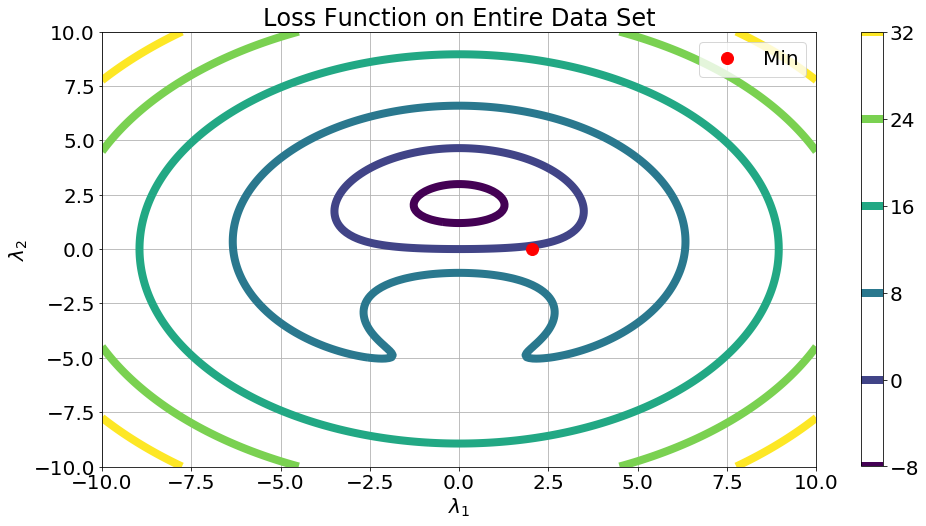

In [6]:
# 2.1 Visualize the loss function

# Minimum is given
lambda1_min = 2.05384
lambda2_min = 0.0
# lambda_min = np.array([lambda1_min, lambda2_min])
loss_min = L(lambda1_min, lambda2_min)

# Grid of lambda1 and lambda2
grid_size: int = 200
lambda1_samp = np.linspace(-10, 10, grid_size)
lambda2_samp = np.linspace(-10, 10, grid_size)
lambda1_grid, lambda2_grid = np.meshgrid(lambda1_samp, lambda2_samp)

# Grid of the total loss function
try:    
    loss_grid = vartbl['loss_grid']
except:    
    loss_grid = np.zeros((grid_size, grid_size))
    for i, lambda1 in enumerate(lambda1_samp):
        for j, lambda2 in enumerate(lambda2_samp):
            loss_grid[i,j] = L(lambda1, lambda2)
    vartbl['loss_grid'] = loss_grid
    save_vartbl(vartbl, fname)

# Plot the loss function
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('Loss Function on Entire Data Set')
ax.set_xlabel(r'$\lambda_1$')
ax.set_ylabel(r'$\lambda_2$')
cs = ax.contour(lambda1_grid, lambda2_grid, loss_grid, linewidths=8)
ax.plot(lambda1_min, lambda2_min, label='Min', marker='o', markersize=12, linewidth=0, color='r')
fig.colorbar(cs, ax=ax)
ax.legend()
ax.grid()
plt.show()

In [7]:
# 2.2. Choose an appropriate learning rate from [10, 1, 0.1, 0.01, 0.001, 0.0001] and 
# use that learning rate to implement gradient descent. Use your implementation to minimize L for the given data. 
# Your implementation should be stored in a function named gradient_descent.  
# gradient_descent should take the following parameters (n represents the number of data points):

def gradient_descent(lambda_init, X_data, step_size, scale, max_iterations, precision, loss):
    """
    Gradient Descent algorithm specialized for this problem.

    INPUTS:
    ======
    lambda_init    -- a numpy array with shape (2, 1) containing the initial value for λ1 and λ2 
    X_data         -- an numpy array with shape (n, 2) containing the data coordinates used in your loss function
    step_size      -- a float containing the step-size/learning rate used in your algorithm
    scale          -- a float containing the factor by which you'll scale your step_size 
                     (or alternatively your loss) in the algorithm
    max_iterations -- an integer containing a cap on the number of iterations for which you'll let your algorithm run
    precision      -- a float containing the difference in loss between consecutive iterations below which 
                      you'll stop the algorithm
    loss           -- a function (or lambda function) that takes in the following parameters and returns a float 
                      with the results of calculating the loss function for our data at λ1 and λ2 
            lambdas        -- a numpy array with shape (2, 1) containing  λ1 and λ2 
            X_data         -- the same as the parameter X_data for gradient_descent
    
    RETURNS:
    =======
    Dictionary with the following keys (n_iterations represents the total number of iterations):
    'lambdas' -- the associated value is a numpy array with shape (2,1) containing 
                 the optimal λ's found by the algorithm
    'history' -- the associated value is a numpy array with shape (n_iterations,) containing a 
                 history of the calculated value of the loss function at each iteration        
    """
    # Initialize lambdas to lambda_init
    lambdas = lambda_init
    # Initialize history to have size max_iterations
    history = np.zeros(max_iterations+1)
    # Set shift size h for numerical derivatives of lambda1 and lambda2; use sqrt(machine_epsilon)
    h: float = 2**-26
    two_h: float = 2*h
    # Vectorized shifts to lambdas
    h_lam1 = np.array([h, 0])
    h_lam2 = np.array([0, h])
    # Initialize loss_prev to the loss on the initial parameter values
    loss_prev: float = loss(X_data, lambdas)
    history[0] = loss_prev
    # Perform up to max_iterations steps of gradient descent
    for i in range_inc(max_iterations):
        # Compute partial of loss w.r.t lambda1 and lambda2
        dL_dlam1 = (loss_func(X_data, lambdas + h_lam1) - loss_func(X_data, lambdas - h_lam1)) / two_h
        dL_dlam2 = (loss_func(X_data, lambdas + h_lam2) - loss_func(X_data, lambdas - h_lam2)) / two_h
        # Vector gradient dL_dlam
        grad = np.array([dL_dlam1, dL_dlam2])
        # Subtract a multiple of the gradient from lambdas
        lambdas = lambdas - step_size * grad
        # Compute the current loss
        loss_curr = loss(X_data, lambdas)
        # Save the current loss in the history
        history[i] = loss_curr
        # Compute the change in the loss function 
        loss_change = loss_prev - loss_curr
        # Update loss_prev
        loss_prev: float = loss_curr
        # Update step_size using scale
        step_size *= scale
        # Was the improvement below the precision? Then we can terminate
        if loss_change < precision:
            break
    # Prune history to the number of steps taken
    history = history[0:i+1]
    # Create the answer dictionary and return it
    gd = {'lambdas': lambdas, 
          'history' : history}
    return gd

In [8]:
# 2.2
# Run the gradient descent starting at [0, 0] with a learning rate of 0.01
lambda_init = np.array([0.0, 0.0])
step_size = 0.01
scale = 1.0
max_iterations=10000
precision=1e-12
t0 = time()
gd = gradient_descent(lambda_init, X_data, step_size, scale, max_iterations, precision, loss_func)
t1 = time()
elapsed_gd = (t1-t0)
# Unpack answer
lambdas_gd = gd['lambdas']
history_gd = gd['history']
lambda1_gd, lambda2_gd = lambdas_gd
num_iters_gd = len(history_gd)-1
print(f'Completed gradient descent to precision {precision:0.2e} in {num_iters_gd} steps.')
print(f'lambda1 = {lambda1_gd:0.6f}, lambda2 = {lambda2_gd:0.6f}')
print(f'Elapsed time {elapsed_gd:0.2f} seconds, {elapsed_gd/num_iters_gd:0.2e} per second.')

Completed gradient descent to precision 1.00e-12 in 264 steps.
lambda1 = 2.053846, lambda2 = 0.000000
Elapsed time 0.31 seconds, 1.17e-03 per second.


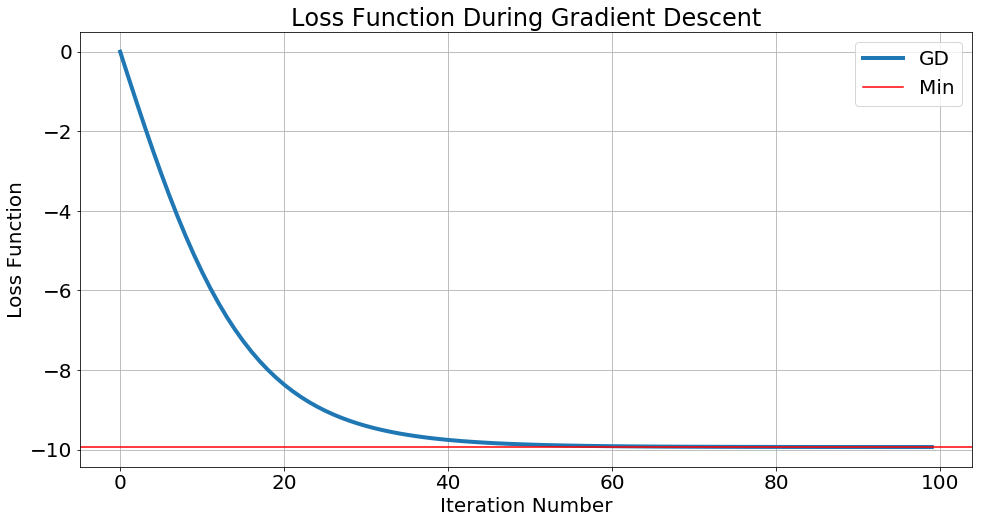

In [9]:
# 2.3 For your implementation in 2.2, create a plot of loss vs iteration. 
# Does your descent algorithm comverge to the right values of  λ ? At what point does your implementation converge?

plot_n_gd = np.arange(num_iters_gd+1)
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('Loss Function During Gradient Descent')
ax.set_xlabel('Iteration Number')
ax.set_ylabel('Loss Function')
ax.plot(plot_n_gd[0:100], history_gd[0:100], label='GD', linewidth=4)
ax.axhline(y=loss_min, color='r', label='Min')
ax.legend()
ax.grid()
plt.show()

**2.3** The gradient descent algorithm successfully converged to a precision of 1e-12 after 264 steps.  It found the correct values of $\lambda_1$ and $\lambda_2$ to within 6 decimal places.  The chart above only displays the first 100 iterations to give a better visual of the progress.  Between 100 and 264 it's making progress that's not visible on the chart.

In [10]:
# 2.4. Choose an appropriate learning rate from [10, 1, 0.1, 0.01, 0.001, 0.0001] 
# and use that learning rate to implement stochastic gradient descent. Use your implementation to minimize 
# L for the given data. Your implementation should a stored in a function named stochastic_gradient_descent. 
# stochastic_gradient_descent should take the following parameters (n represents the number of data points):

def stochastic_gradient_descent(lambda_init, X_data, step_size, scale, max_iterations, precision, loss):
    """
    Stochastic Gradient Descent algorithm specialized for this problem.

    INPUTS
    ======
    lambda_init    -- a numpy array with shape (2, 1) containing the initial value for λ1 and λ2 
    X_data         -- an numpy array with shape (n, 2) containing the data coordinates used in your loss function
    step_size      -- a float containing the step-size/learning rate used in your algorithm
    scale          -- a float containing the factor by which you'll scale your step_size 
                     (or alternatively your loss) in the algorithm
    max_iterations -- an integer containing a cap on the number of iterations for which you'll let your algorithm run
    precision      -- a float containing the difference in loss between consecutive iterations below which 
                      you'll stop the algorithm
    loss           -- a function (or lambda function) that takes in the following parameters and returns a float 
                      with the results of calculating the loss function for our data at λ1 and λ2 
            lambdas        -- a numpy array with shape (2, 1) containing  λ1 and λ2 
            X_data         -- the same as the parameter X_data for gradient_descent
    
    RETURNS:
    =======
    Dictionary with the following keys (n_iterations represents the total number of iterations):
    'lambdas' -- the associated value is a numpy array with shape (2,1) containing 
                 the optimal λ's found by the algorithm
    'history' -- the associated value is a numpy array with shape (n_iterations,) containing a 
                 history of the calculated value of the loss function at each iteration        
    """

    # Initialize lambdas to lambda_init
    lambdas = lambda_init
    # Initialize history to have size max_iterations
    history = np.zeros(max_iterations+1)
    # Set shift size h for numerical derivatives of lambda1 and lambda2; use sqrt(machine_epsilon)
    h: float = 2**-26
    two_h: float = 2*h
    # Vectorized shifts to lambdas
    h_lam1 = np.array([h, 0])
    h_lam2 = np.array([0, h])
    # Initialize loss_prev to the loss on the initial parameter values
    loss_prev: float = loss(X_data, lambdas)
    history[0] = loss_prev
    # Shape of data
    m, n = X_data.shape
    # Copy X so we don't re-order it when shuffling
    X = X_data.copy()
    # Perform up to max_iterations steps of gradient descent
    for epoch in range_inc(max_iterations):
        # Shuffle the data randomly for this epoch
        np.random.shuffle(X)
        # Iterate over individual points in X
        for i in range(m):
            # Extract the ith row
            row = X[i, :].reshape(-1,2)
            # Compute partial of loss w.r.t lambda1 and lambda2
            dL_dlam1 = (loss_func(row, lambdas + h_lam1) - loss_func(row, lambdas - h_lam1)) / two_h
            dL_dlam2 = (loss_func(row, lambdas + h_lam2) - loss_func(row, lambdas - h_lam2)) / two_h
            # Vector gradient dL_dlam
            grad = np.array([dL_dlam1, dL_dlam2])
            # Subtract a multiple of the gradient from lambdas
            lambdas = lambdas - step_size * grad
        # Compute the current loss
        loss_curr = loss(X_data, lambdas)
        # Save the current loss in the history
        history[epoch] = loss_curr
        # Compute the change in the loss function 
        loss_change = loss_prev - loss_curr
        # Update loss_prev
        loss_prev: float = loss_curr
        # Update step_size using scale
        step_size *= scale
        # Was the improvement below the precision? Then we can terminate
        if loss_change < precision:
            break
    # Prune history to the number of steps taken
    history = history[0:epoch+1]
    # Create the answer dictionary and return it
    sgd = {'lambdas': lambdas, 
          'history' : history}
    return sgd

In [11]:
# 2.4
# Run the gradient descent starting at [0, 0] with a learning rate of 0.01
lambda_init = np.array([0.0, 0.0])
step_size = 0.01
scale = 1.0
max_iterations=300
precision=1e-6

# Load the sgd if present, otherwise compute it
try:
    sgd = vartbl['sgd']    
    elapsed_sgd = vartbl['elapsed_sgd']
    save_vartbl(vartbl, fname)
except:
    t0 = time()
    sgd = stochastic_gradient_descent(lambda_init, X_data, step_size, scale, max_iterations, precision, loss_func)
    t1 = time()
    elapsed_sgd = t1 - t0
    vartbl['sgd'] = sgd
    vartbl['elapsed_sgd'] = elapsed_sgd
        
# Unpack answer
lambdas_sgd = sgd['lambdas']
history_sgd = sgd['history']
lambda1_sgd, lambda2_sgd = lambdas_sgd
num_iters_sgd = len(history_sgd)-1
print(f'Completed stochastic gradient descent to precision {precision:0.2e} in {num_iters_sgd} steps.')
print(f'lambda1 = {lambda1_sgd:0.6f}, lambda2 = {lambda2_sgd:0.6f}')
print(f'Elapsed time {elapsed_sgd:0.2f} seconds, {elapsed_sgd/num_iters_gd:0.2e} per second.')

Completed stochastic gradient descent to precision 1.00e-06 in 108 steps.
lambda1 = 2.052280, lambda2 = 0.000000
Elapsed time 144.02 seconds, 5.46e-01 per second.


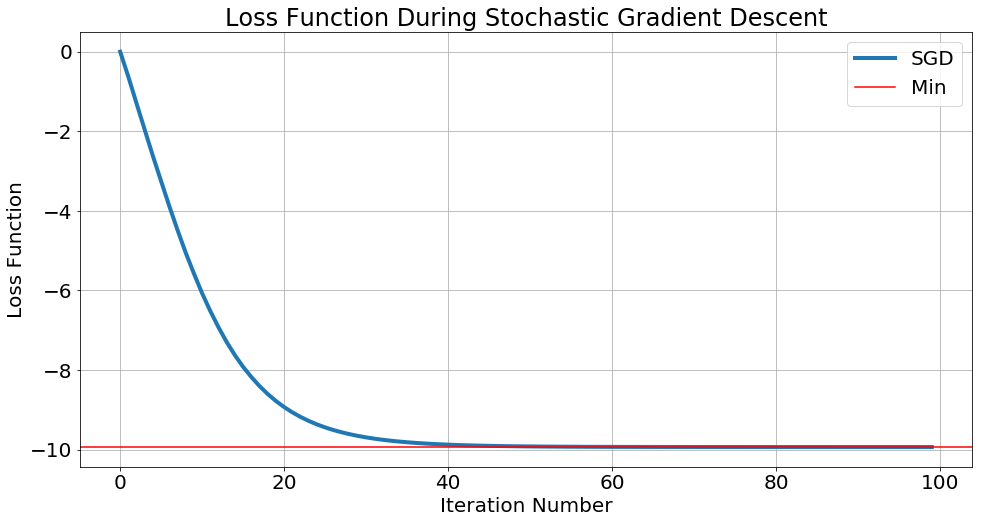

In [13]:
# 2.5 For your implementation in 2.4, create a plot of loss vs iteration. 
# Does your descent algorithm comverge to the right values of λ ? At what point does your implementation converge?
    
plot_n_sgd = np.arange(num_iters_sgd+1)
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('Loss Function During Stochastic Gradient Descent')
ax.set_xlabel('Iteration Number')
ax.set_ylabel('Loss Function')
ax.plot(plot_n_sgd[0:100], history_sgd[0:100], label='SGD', linewidth=4)
ax.axhline(y=loss_min, color='r', label='Min')
ax.legend()
ax.grid()
plt.show()

**2.5** The stochastic gradient descent also converged to values that were essentially close.  $\lambda_1$ didn't match past the first two decimal places, but the loss function was very close to what it was at the minimum, so for practical purposes it found the right answer.  It took 108 steps to achieve a tolerance of 1e-6.  Interestingly when we plot the loss once per epoch, we don't see the loss function bouncing around, which is possible in SGD in general.  This suggests that the choice of learning rate was adequate (probably not too big in any case).

**2.6** SGD was **much** slower than the "regular" gradient descent (on the full data set).  The Gradient Descent algorithm needed just 0.35 seconds to complete 264 iterations, costing 1.31 milliseconds per iteration.  The Stochastic Gradient Descent needed 144 seconds (i.e. 2:24) for 108 iterations, a cost of 546 milliseconds per iteration.  So one iteration of SGD cost about 417 times longer than an iteration of GD.

It's possible that some of this slowness was due to efficient vectorization in GD vs. poorly written for loops in SGD, but most of the slowdown is probably real.  SGD is doing a ton of extra work taking derivatives at every point, whereas GD is doing that work only once per epoch.  Another way of describing this situation is that the optimal mini-batch size for this problem is closer to the full data set than to one point at a time.  One point at a time is almost never optimal because of the overhead involved in calling functions and computing gradients.  You essentially always want a mini batch that's big enough to amortize those costs.

In [14]:
# Number of iterations for 3 decimal places of precision in the loss function
precision_3dp = 1e-3
gd_3dp = gradient_descent(lambda_init, X_data, step_size, scale, max_iterations, precision_3dp, loss_func)
# Load gradient descent calculations to 3 decimal places if present, otherwise compute it
try:
    sgd_3dp = vartbl['sgd_3dp']
except:
    sgd_3dp = stochastic_gradient_descent(lambda_init, X_data, step_size, scale, 
                                          max_iterations, precision_3dp, loss_func)
    vartbl['sgd_3dp'] = sgd_3dp
    save_vartbl(vartbl, 'sgd_3dp')
# Report results
num_iters_gd_3dp = len(gd['history'])
num_iters_sgd_3dp = len(sgd['history'])
print(f'Number of iterations for 3 decimal places of accuracy:')
print(f'Gradient Descent           : {num_iters_gd_3dp} iterations')
print(f'Stochastic Gradient Descent: {num_iters_sgd_3dp} iterations')

Number of iterations for 3 decimal places of accuracy:
Gradient Descent           : 265 iterations
Stochastic Gradient Descent: 109 iterations


**2.7** The Stochastic Gradient Descent algorithm takes fewer iterations (265) to converge than the full Gradient Descent algorithm (109).  This is as expected.  One iteration of work on SGD involves taking one tiny step for every single data point in the data set.  This is more computationally expensive, which is why SGD takes longer per iteration.  It also means that one iteration of SGD is more informative.  By evaluating the data points in small batches (here of size 1), SGD is able to learn more over a full iteration than GD.  The early steps in the epoch allow the objective function to get closer, on average, to the minimum, making the average of all 16,000 steps better than a single step for the full data set.  With that said, a batch size of 16,000 (full data set) is clearly superior on this problem to a batch size of 1.

The optimal mini-batch size is somewhere in between, and would aim to hit the sweet spot of trading off between competing objectives.  Smaller batch sizes allow for more of this benefit to learning a little bit on each step, benefiting the later steps.  Larger batch sizes allow for more accurate derivatives to be taken and for efficiencies due to vectorization and amortizing overhead from function calls.  The most efficient batch size on a given problem is not at all obvious and can only be verified experimentally.  If I were going to make up a number on this problem, I'd probably try 1024 to start, and then perhaps different powers of 2 in both directions.

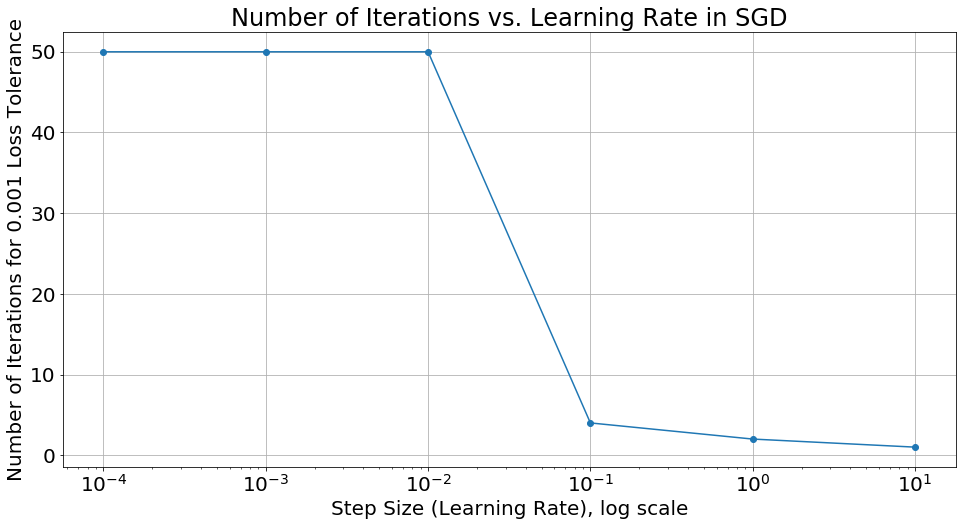

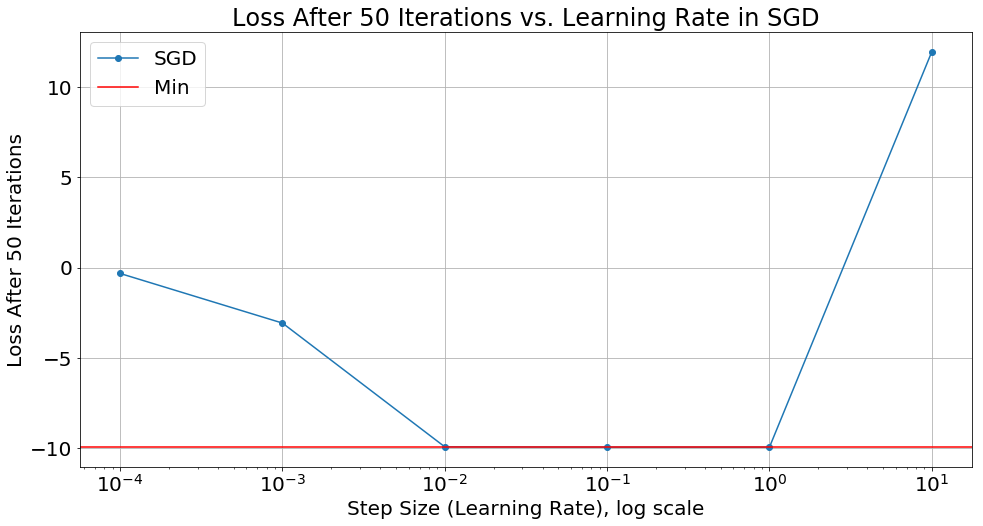

In [15]:
# List of learning rates to try
step_sizes  = np.array([10.0, 1.0, 0.1, 0.01, 0.001, 0.0001])
num_step_sizes = len(step_sizes)
# Set initial value
lambda_init = np.array([0, 0])
# Set max_iterations for this experiment at 50 so runs don't take too long
max_iterations_sgd = 50
# Load SGD by learning rate if present, otherwise compute it
try:
    sgds_by_lr = vartbl['sgds_by_lr']
    num_iters_by_lr = vartbl['num_iters_by_lr']
    loss_by_lr = vartbl['loss_by_lr']
except:       
    # List of sgd objects and iteration counts
    sgds_by_lr: List[dict] = num_step_sizes * [dict()]
    num_iters_by_lr = np.zeros(num_step_sizes)
    loss_by_lr = np.zeros(num_step_sizes)
    # Try each step size on SGD; count number of iterations for 3 decimal places
    for i, step_size in enumerate(step_sizes):
        sgd_curr = stochastic_gradient_descent(lambda_init, X_data, step_size, 
                                               scale, max_iterations_sgd, precision_3dp, loss_func)
        sgds_by_lr[i] = sgd_curr
        num_iters_by_lr[i] = len(sgd_curr['history'])-1
        loss_by_lr[i] = sgd_curr['history'][-1]
    vartbl['sgds_by_lr'] = sgds_by_lr
    vartbl['num_iters_by_lr'] = num_iters_by_lr
    vartbl['loss_by_lr'] = loss_by_lr
    save_vartbl(vartbl, fname)

# Plot number of iterations vs. learning rate
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('Number of Iterations vs. Learning Rate in SGD')
ax.set_xlabel('Step Size (Learning Rate), log scale')
ax.set_ylabel('Number of Iterations for 0.001 Loss Tolerance')
ax.set_xscale('log')
ax.plot(step_sizes, num_iters_by_lr, label='SGD', marker='o')
ax.grid()
plt.show()

# Plot error after 50 iterations vs. learning rate for three small ones
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('Loss After 50 Iterations vs. Learning Rate in SGD')
ax.set_xlabel('Step Size (Learning Rate), log scale')
ax.set_ylabel('Loss After 50 Iterations')
ax.set_xscale('log')
ax.plot(step_sizes, loss_by_lr, label='SGD', marker='o')
ax.axhline(y=loss_min, color='r', label='Min')
ax.legend()
ax.grid()
plt.show()

**2.8** The learning rate is a crucial parameter impacting the performance of the SGD algorithm.  I capped the number of iterations to 50 to keep the run time manageable.  We can see two plots above: one is the number of iterations until termination, the other is the final loss function.

The three intermediate learning rates of 0.01, 0.1, and 1.0 all converged successfully close to the optimal loss value near -10 within the budget of 50 iterations.  For learning rates below 1, the smaller the learning rate, the slower the convergence was.  The setting of 0.01 did not in fact terminate within 0.001, but used up its budget of 50 iterations.  Still it got pretty close.  The tiny values of 0.001 and 0.0001 made little and no progress, respectively.
The steady improvement in performance as we increased the learning rate abruptly fell off a cliff with a learning rate of 10.0.  That was clearly too big and led to overshooting.  Interestingly, the algorithm did terminate, but it did so at a point that was not optimal by a longshot.

The takeaway here is that increasing the learning rate steadily improves performance until it leads to overshooting, at which point it has a catastrophic effect on performance.

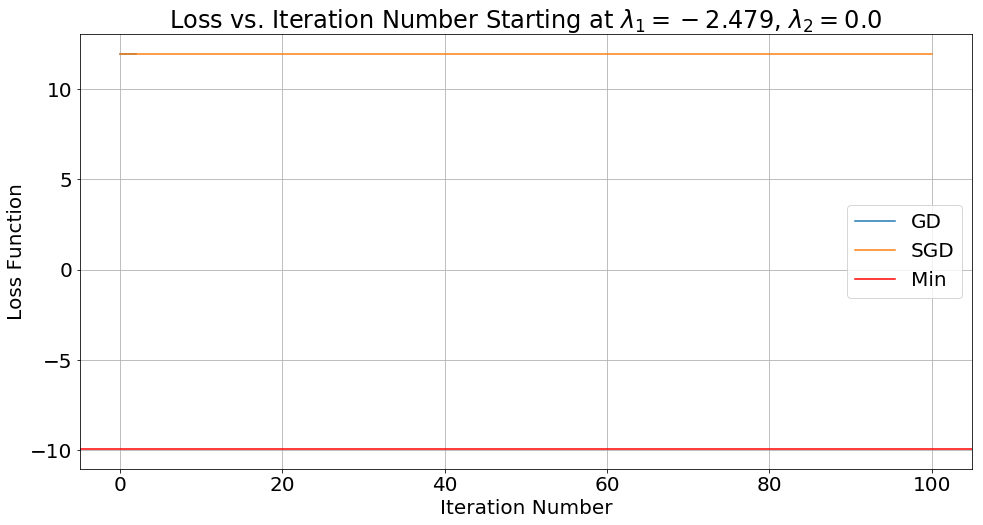

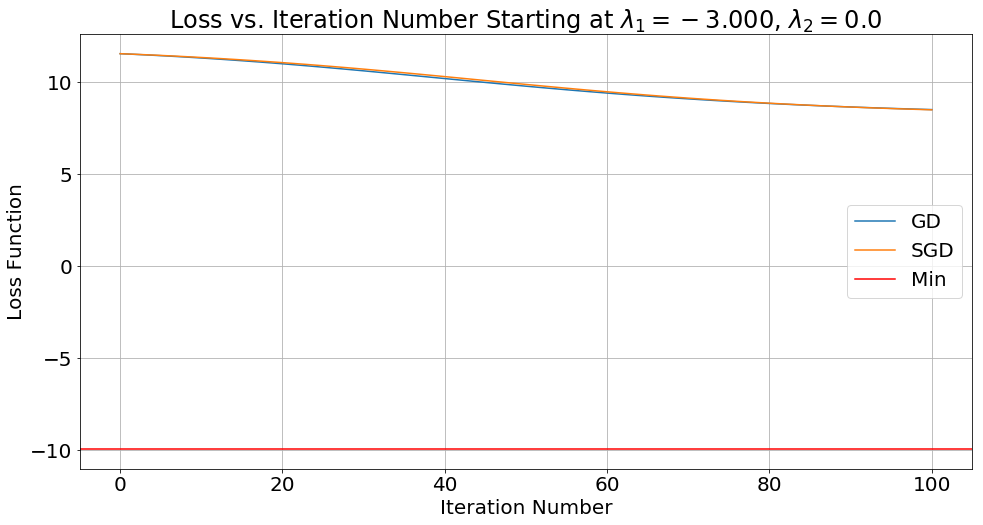

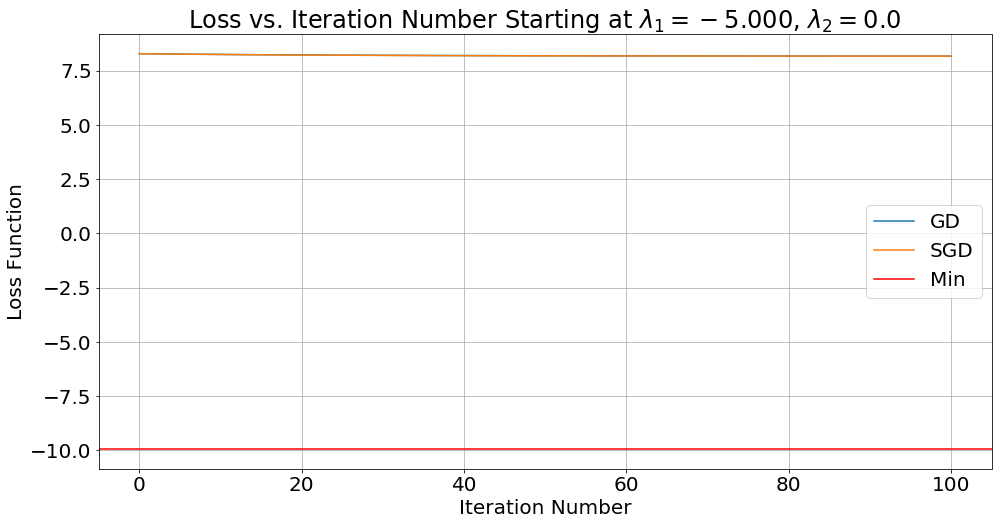

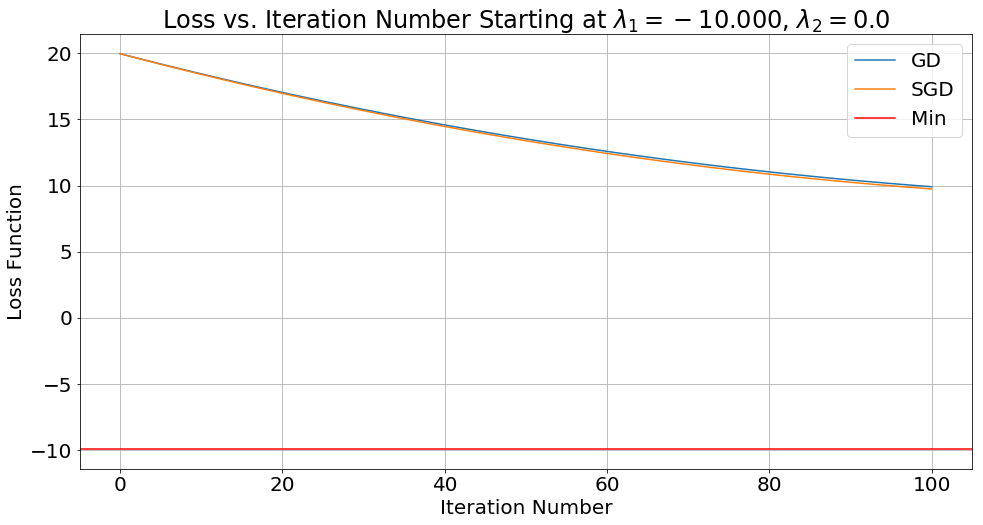

In [17]:
# 2.9 Using your implementation of gradient descent and stochastic gradient descent, document the behavior of your two
# algorithms for the following starting points, and for a number of stepsizes of your choice:
# (λ1, λ2) =(−2.47865,0)
# (λ1, λ2) =(−3,0)
# (λ1, λ2) =(−5,0)
# (λ1, λ2) =(−10,0)
# Construct a mathematical analysis of the loss function L to explain results of your descent 
# algorithms at different starting points.

# List of starting points
lambda1s_init: List[float] = [-2.47865, -3.0, -5.0, -10.0]
lambdas_init = [np.array([x, 0.0]) for x in lambda1s_init]
num_starts = len(lambdas_init)
# Use a consistent benchmark for the number of steps
max_iterations = 100
# Set a learning rate of 1.0 here
scale = 1.0
# Set a very tight precision so we won't exit early
precision_tight = 1e-16
# Test whether this has been done on a prior run in this session because it's slow
try:
    gds_by_start = vartbl['gds_by_start']
    sgds_by_start = vartbl['sgds_by_start']                           
except:
    # Create lists to store the results
    gds_by_start = num_starts * [dict()]
    sgds_by_start = num_starts * [dict()]
    # Iterate over each starting point
    for i, lambda_init in enumerate(lambdas_init):
        # Run both gradient descent algorithms with this starting point
        gd_curr = gradient_descent(lambda_init, X_data, step_size, 
                                   scale, max_iterations, precision_tight, loss_func)
        sgd_curr = stochastic_gradient_descent(lambda_init, X_data, step_size, 
                                               scale, max_iterations, precision_tight, loss_func)
        # Save the two models
        gds_by_start[i] = gd_curr
        sgds_by_start[i] = sgd_curr
    # Save these calculations
    vartbl['gds_by_start'] = gds_by_start
    vartbl['sgds_by_start'] = sgds_by_start
    save_vartbl(vartbl, fname)
            

# Loss function vs. iteration iteration for each starting value
loss_gd_by_start = num_starts * [np.array([])]
loss_sgd_by_start = num_starts * [np.array([])]

for i, lambda_init in enumerate(lambdas_init):
    loss_gd_by_start[i] = gds_by_start[i]['history']
    loss_sgd_by_start[i] = sgds_by_start[i]['history']

# Plot loss vs. iteration for each start
nn = arange_inc(0, max_iterations)
for i, lambda_init in enumerate(lambdas_init):
    lambda1, lambda2 = lambda_init
    fig, ax = plt.subplots()
    fig.set_size_inches([16,8])
    ax.set_title(f'Loss vs. Iteration Number Starting at $\lambda_1={lambda1:0.3f}$, $\lambda_2={lambda2:0.1f}$')
    ax.set_xlabel('Iteration Number')
    ax.set_ylabel('Loss Function')
    # Data to plot on this iteration - loss by iteration for GD & SGD
    plot_loss_gd = loss_gd_by_start[i]
    plot_loss_sgd = loss_sgd_by_start[i]
    n_gd = plot_loss_gd.shape[0]
    n_sgd = plot_loss_sgd.shape[0]
    # Plot the loss by iteration
    ax.plot(nn[0:n_gd], plot_loss_gd, label='GD')
    ax.plot(nn[0:n_sgd], plot_loss_sgd, label='SGD')
    ax.axhline(y=loss_min, color='r', label='Min')
    ax.legend()
    ax.grid()
    plt.show()
    
# Save all persisted variable
save_vartbl(vartbl, fname)

In the charts above, we can see that gradient descent is quite sensitive to the starting point chosen.
For the first trial point with $\lambda_1 = -2.479$, neither algorithm makes any progress over 100 iterations.  This suggests the loss function has a local minimum near these two values.

<div class="answer-separator">
------------------------
</div>